In [1]:
# load modules
import os
import numpy as np
import pandas as pd
import pickle

# Plotting imports
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

import palantir
import scanpy.api as sc
sc.settings.verbosity = 5

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


In [2]:
import random
random.seed(100)

In [3]:
%matplotlib inline

## Download data

Anndata objects with all the data and metadata are publically avaiable at: https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep[1-3].h5ad. This notebook use replicate 1 (https://s3.amazonaws.com/dp-lab-data-public/palantir/human_cd34_bm_rep1.h5ad) for illustration. 

Description of the anndata object is available at https://s3.amazonaws.com/dp-lab-data-public/palantir/readme

## Load data

In [4]:
# Load the AnnData object
ad = sc.read('annadata/human_cd34_bm_rep1.h5ad')
colors = pd.Series(ad.uns['cluster_colors'])
ct_colors = pd.Series(ad.uns['ct_colors'])

## Monocle 2

In [5]:
boundary_clusters = pd.Series([])
boundary_clusters['HSC'] = 0
boundary_clusters['Mono'] = 3
boundary_clusters['Mega'] = 9
boundary_clusters['CLP'] = 5
boundary_clusters['Ery'] = 8
boundary_clusters['DC'] = 7

In [6]:
# Gene subsets to be used for Monocle 2
statistic = pd.DataFrame(ad.varm['mast_diff_res_statistic'], 
                        index=ad.var_names, columns=ad.uns['mast_diff_res_columns'])

gene_subsets = dict()
for ct in boundary_clusters.index:
    print(ct)
    others = boundary_clusters.index.difference([ct])
    index = 'Cluster{}'.format(boundary_clusters[ct])

    genes = statistic.index[(statistic.loc[:, index] > 0.1) &
                            (statistic.iloc[:, boundary_clusters[others]].max(axis=1) < 0.25)]
    genes = statistic.loc[genes, index].sort_values().index[::-1]

    if ct == 'DC':
        genes = genes[:100]
    if ct == 'Mega' or ct == 'CLP':
        genes = genes[:250]

    print(len(genes))
    gene_subsets[ct] = list(genes)


HSC
281
Mono
274
Mega
250
CLP
250
Ery
584
DC
100


We export data and use the Monocle2 R Script to compute the results. The exporting code is shown below

```
# Export data 
monocle_dir = 'monocle2/'
os.makedirs(monocle_dir, exist_ok=True)

# Genes
genes = np.unique(np.concatenate(list(gene_subsets.values())))
# Expression matrix
counts = pd.DataFrame(ad.raw.X.todense(), index=ad.obs_names, columns=ad.var_names)
pd.DataFrame(counts).to_csv(f'{monocle_dir}/counts.csv')
pd.DataFrame(genes).to_csv(f'{monocle_dir}/genes.csv')
```

R snippet used is shown below was saved as ```monocle_wrapper.R```

```
library(monocle, quiet=TRUE)

args <- commandArgs(trailingOnly = TRUE)
out_dir <- args[1]


print('Loading data...')
umi_matrix <- read.csv(sprintf("%s/counts.csv", out_dir), row.names=1)

# Annoated dataframes
pd = data.frame(cell_names = rownames(umi_matrix))
rownames(pd) = rownames(umi_matrix)
fd = data.frame(gene_short_name = colnames(umi_matrix))
rownames(fd) = colnames(umi_matrix)

HSMM <- newCellDataSet(as(t(umi_matrix), "sparseMatrix"),
    phenoData = AnnotatedDataFrame(pd), 
    featureData = AnnotatedDataFrame(fd), 
    expressionFamily=negbinomial.size())

# Size factors and dispersion
print('Size factors and dispersion')
HSMM <- estimateSizeFactors(HSMM)
HSMM <- estimateDispersions(HSMM)


# Differentially expressed genes from clusters
print('Ordering genes...')
ordering_genes <- read.csv(sprintf("%s/genes.csv", out_dir), stringsAsFactors=FALSE)[,2]
HSMM_subset <- setOrderingFilter(HSMM, ordering_genes)


print('Dimensionality reduction...')
HSMM_subset <- reduceDimension(HSMM_subset, max_components = 2,
    method = 'DDRTree')


HSMM_subset <- orderCells(HSMM_subset)
# early_cell = 'Run5_205922701598003'
early_cell = 'GSM2743164_rep1_tmouse_1068'
# Rerun with early state
HSMM_subset <- orderCells(HSMM_subset, root_state = pData(HSMM_subset)[early_cell, 'State'])


save(HSMM_subset, file=sprintf("%s/HSMM_subset.rda", out_dir))
write.csv(pData(HSMM_subset), sprintf("%s/phenodata.csv", out_dir), quote=FALSE)
write.csv(reducedDimS(HSMM_subset), sprintf("%s/red_dims.csv", out_dir), quote=FALSE)

```

The above script was invoked as shown below

```
import subprocess

ss_path = 'monocle2/monocle_wrapper.R'
args = f'Rscript {ss_path} {monocle_dir}'
print('Running Monocle2 using: {}\n'.format(args))
with subprocess.Popen(args,
                      stdout=None, stderr=subprocess.PIPE,
                      shell=True) as p:
    out, err = p.communicate()

```

The results from the above run is available at ```results/monocle2```

### Load results 

In [7]:
pdata = pd.read_csv('results/monocle2/phenodata.csv', index_col=0)
rdims = pd.read_csv('results/monocle2/red_dims.csv', index_col=0).T
rdims.columns = ['x', 'y']

### States

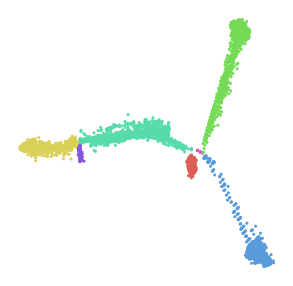

In [8]:
plt.figure(figsize=[5, 5])
s_colors = sns.color_palette('hls', len(pdata.State.unique())).as_hex()
s_colors = pd.Series(s_colors, index = pdata.State.unique())
plt.scatter(rdims.loc[:, 'x'], rdims.loc[:, 'y'], s=5, 
           color=s_colors[pdata.State])
ax = plt.gca()
ax.set_axis_off()

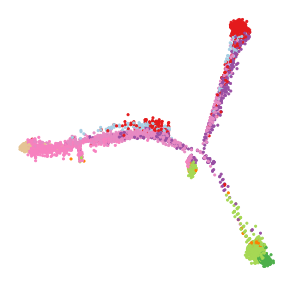

In [9]:
plt.figure(figsize=[5, 5])
plt.scatter(rdims.loc[:, 'x'], rdims.loc[:, 'y'], s=5, 
           color=colors[ad.obs['clusters']])
ax = plt.gca()
ax.set_axis_off()

### Gene expression

In [10]:
imputed_data = pd.DataFrame(ad.obsm['MAGIC_imputed_data'], 
                           index=ad.obs_names, columns=ad.var_names)

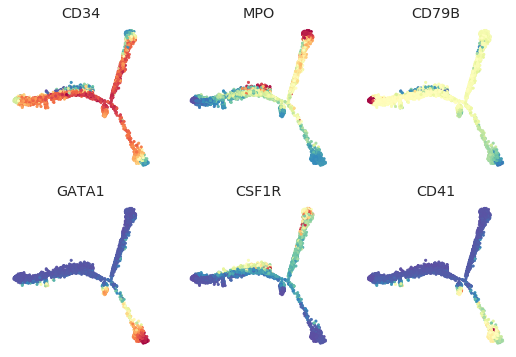

In [11]:
genes = ['CD34', 'MPO', 'CD79B', 'GATA1', 'CSF1R', 'ITGA2B']
labels = ['CD34', 'MPO', 'CD79B', 'GATA1', 'CSF1R', 'CD41']

fig = palantir.plot.FigureGrid(6, 3)
for gene, label, ax in zip(genes, labels, fig):
    ax.scatter(rdims.loc[:, 'x'], rdims.loc[:, 'y'], 
              s=5, cmap=matplotlib.cm.Spectral_r, c=imputed_data.loc[rdims.index, gene])
    ax.set_axis_off()
    ax.set_title(label)
